# VIX-Adjusted Momentum (INDIA)

Replicating [VIX-Adjusted Momentum](https://cssanalytics.wordpress.com/2014/07/29/vix-adjusted-momentum/) using India VIX and the NIFTY 50 index.

In [1]:
library(tidyverse)
library(ggthemes)
library(reshape2)
library(odbc)
library(plutoR)
library(quantmod)
library(lubridate)
library(ggrepel)
library(PerformanceAnalytics)

options("scipen"=999)
options(stringsAsFactors = FALSE)
options(repr.plot.width=16, repr.plot.height=8)

source("config.R")
source("goofy/plot.common.R")
source("goofy/misc.common.R")

indices <- Indices()

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.1
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths

Loading required package: xts
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Attaching package: ‘xts’

The following objects are masked from ‘package:dplyr’:

    first, last

Loading required package: TTR
Version 0.4-0 included new data defaults. See ?getSymbols.

Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date


Attaching package: ‘PerformanceAnalytics’

The following obje

In [2]:
startDate <- as.Date('2009-03-03') #the day when India VIX was launched
endDate <- as.Date('2019-06-30')

vixDt <- indices$IndiaVixTimeSeries() %>%
    filter(TIME_STAMP >= startDate & TIME_STAMP <= endDate) %>%
    select(TIME_STAMP, CLOSE) %>%
    collect()
    
nifty50Dt <- indices$NseTimeSeries() %>%
    filter(NAME == 'NIFTY 50' & TIME_STAMP >= startDate & TIME_STAMP <= endDate) %>%
    select(TIME_STAMP, CLOSE) %>%
    collect()

allXts <- merge(xts(nifty50Dt$CLOSE, nifty50Dt$TIME_STAMP), xts(vixDt$CLOSE, vixDt$TIME_STAMP))
names(allXts) <- c('NIFTY', 'VIX')

print(head(allXts))
print(tail(allXts))

             NIFTY   VIX
2009-03-03 2622.40 43.89
2009-03-04 2645.20 42.52
2009-03-05 2576.70 41.49
2009-03-06 2620.15 38.16
2009-03-09 2573.15 40.87
2009-03-12 2617.45 39.27
              NIFTY     VIX
2019-06-21 11724.10 14.6100
2019-06-24 11699.65 15.2225
2019-06-25 11796.45 15.0100
2019-06-26 11847.55 14.7500
2019-06-27 11841.55 14.6450
2019-06-28 11788.85 14.9525


In [3]:
allXts$SMA_200 <- SMA(allXts$NIFTY, 200)
allXts$D_RET <- dailyReturn(allXts$NIFTY)
allXts$D_RET_LAG_1 <- stats::lag(allXts$D_RET, -1) #signal is generated and traded at the close, so use next day's return

allXts$VIX_ADJ_RET <- allXts$D_RET/allXts$VIX
allXts$VIX_ADJ_RET_SMA_200 <- SMA(allXts$VIX_ADJ_RET, 200) 

allXts$ROC_200 <- rollapply(allXts$D_RET, 200, Return.cumulative) #simple compound return or ROC (rate of change) 

allXts <- na.omit(allXts)
print(head(allXts))
print(tail(allXts))

ERROR: Error in runSum(x, n): Series contains non-leading NAs


In [4]:
#go long only if the index is above its 200-day average
allXts$SMA_STRAT <- ifelse(allXts$NIFTY > allXts$SMA_200, allXts$D_RET_LAG_1, 0) 

#go long only if the simple average (VIX-Adjusted Momentum) > 0
allXts$VIX_STRAT <- ifelse(allXts$VIX_ADJ_RET_SMA_200 > 0, allXts$D_RET_LAG_1, 0) 

#go long only if the ROC > 0
allXts$ROC_200_STRAT <- ifelse(allXts$ROC_200 > 0, allXts$D_RET_LAG_1, 0)

ERROR: Error in error(x, ...): improper length of one or more arguments to merge.xts


In [5]:
#plot returns
toPlot <- merge(allXts$VIX_STRAT, allXts$SMA_STRAT, allXts$ROC_200_STRAT, allXts$D_RET_LAG_1)
Common.PlotCumReturns(toPlot, "Back-test", "")

ERROR: Error in fix.by(by.x, x): 'by' must match numbers of columns


In [6]:
#calculate annual returns

byYearDf <- data.frame(T=0, VIX_MOM=0.0, SMA=0.0, ROC=0.0, BH=0.0)

allYears <- unique(year(index(allXts)))
for(yr in allYears){
    byYearDf <- rbind(byYearDf,
                    c(yr, as.numeric(100.0*Return.cumulative(allXts[toString(yr), 'VIX_STRAT'])),
                        as.numeric(100.0*Return.cumulative(allXts[toString(yr), 'SMA_STRAT'])),
                        as.numeric(100.0*Return.cumulative(allXts[toString(yr), 'ROC_200_STRAT'])),
                        as.numeric(100.0*Return.cumulative(allXts[toString(yr), 'D_RET_LAG_1']))))
}

byYearDf <- byYearDf[-1,]
print(byYearDf)

ERROR: Error in `[.xts`(allXts, toString(yr), "VIX_STRAT"): subscript out of bounds


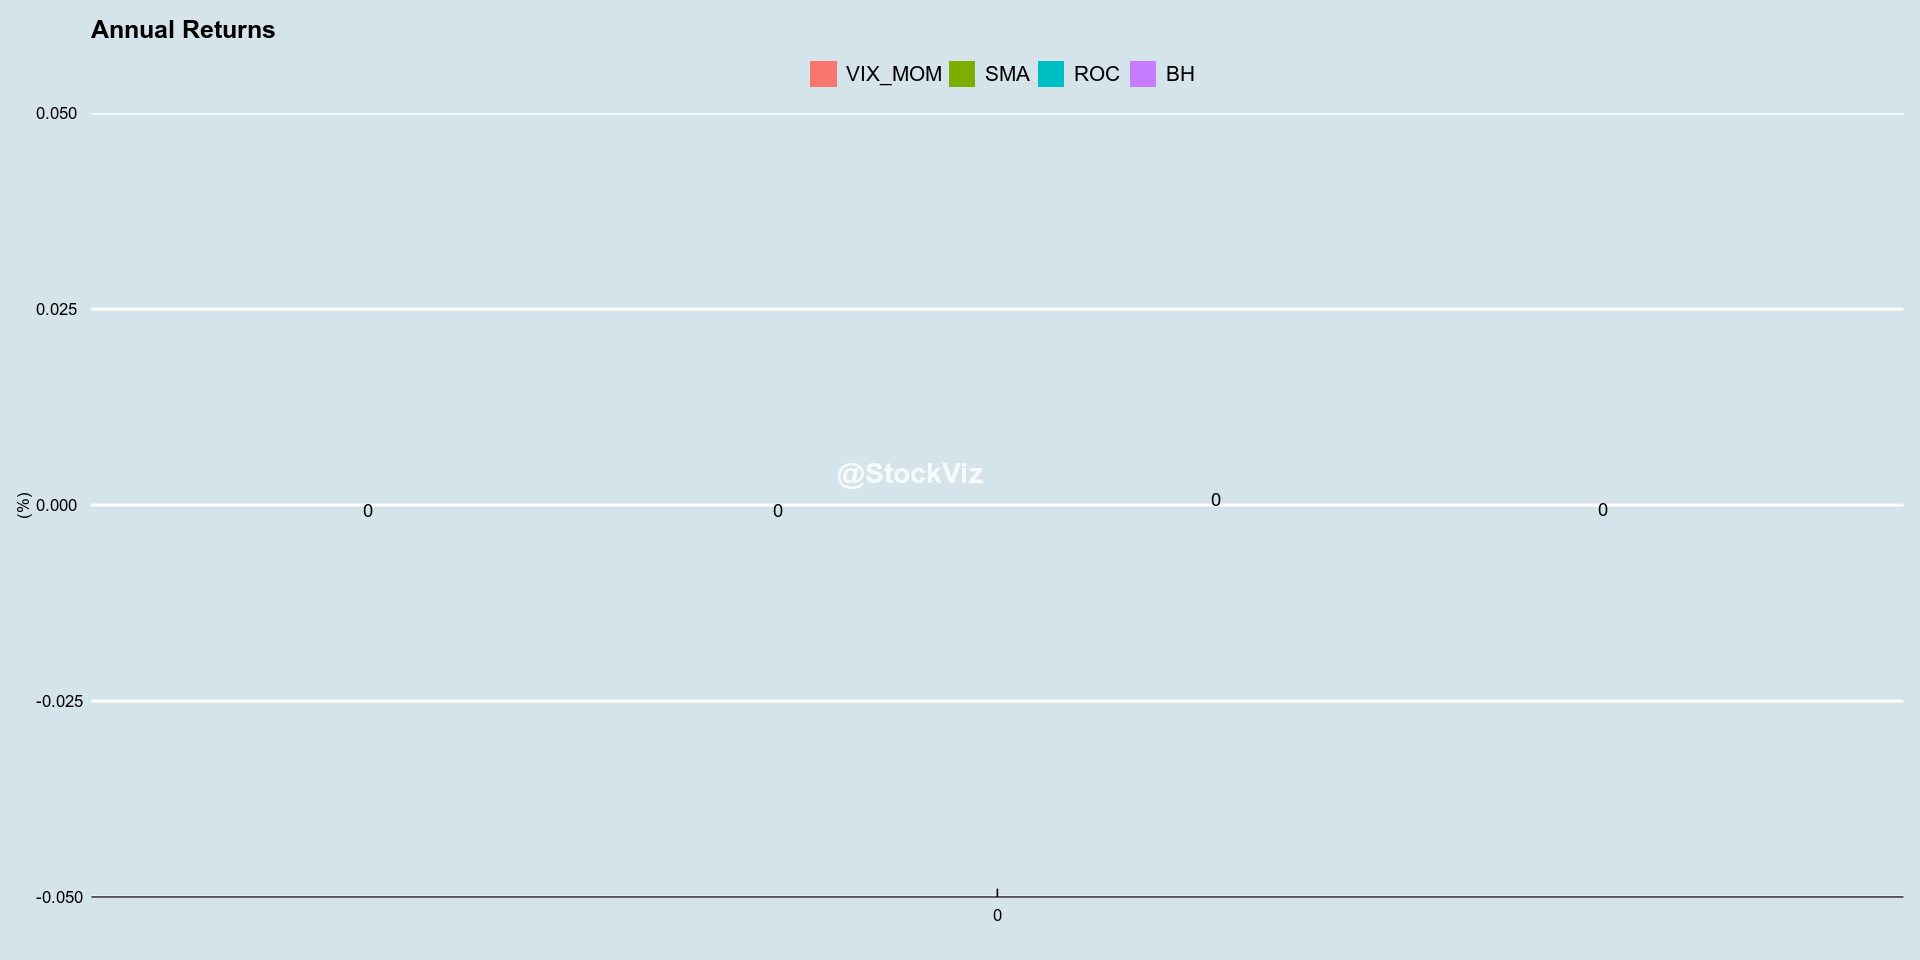

In [7]:
#plot annual returns

ggplot(melt(byYearDf, id='T'), aes(x=T, y=value, fill=variable)) +
    theme_economist() +
    geom_bar(stat="identity", position=position_dodge()) +
    scale_x_continuous(labels=byYearDf$T, breaks=byYearDf$T) +
    geom_text_repel(aes(label= round(value, 2)), position = position_dodge(0.9)) +
    labs(x='', y='(%)', fill='', title=sprintf("Annual Returns")) +
    annotate("text", x=max(byYearDf$T), y=min(sapply(byYearDf[,-1], min, na.rm=T)), 
             label = "@StockViz", hjust=1.1, vjust=-1.1, col="white", cex=6, fontface = "bold", alpha = 0.8)

This notebook was created using [pluto](http://pluto.studio). Learn more [here](https://github.com/shyams80/pluto)